In [1]:
import pandas as pd

from src.dataset import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns


#### Caricamento e preparazione del dataset
In questa sezione vengono caricati i dataset di training relativi alle feature operative (X) e alle variabili target (y).
Successivamente, i due dataset vengono uniti in un unico DataFrame per facilitare l’analisi esplorativa.
Infine, viene ricostruita la variabile trq_target a partire dalla definizione del torque margin.


In [2]:
df_x= load_dataset("data/train/X_train.csv")
df_y = load_dataset("data/train/y_train.csv")
df= pd.concat([df_x,df_y],axis=1)
df["trq_target"] = df["trq_measured"] / (df["trq_margin"] / 100 + 1)

#### Statistiche descrittive di base
Vengono calcolate le statistiche descrittive principali per ottenere una prima visione dei range, della variabilità e dei valori centrali delle variabili.
Questo passaggio consente di individuare eventuali valori anomali e di comprendere le scale delle feature.

In [3]:
df.describe(percentiles=[0.5])

,id,trq_measured,oat,mgt,pa,ias,np,ng,id,faulty,trq_margin,trq_target
count,742625.000000,742625.000000,742625.000000,742625.000000,742625.000000,742625.000000,742625.000000,742625.000000,742625.000000,742625.000000,742625.000000,742625.000000
mean,371312.000000,65.097549,12.675167,592.246116,511.776065,79.324591,97.377919,95.517281,371312.000000,0.403189,-1.157346,66.711490
std,214377.516166,13.253672,8.066084,39.654582,563.190555,35.395075,3.996721,3.635084,214377.516166,0.490538,14.068843,14.170206
min,0.000000,14.673340,-19.250000,467.300000,-208.389200,0.000000,85.010000,90.001830,0.000000,0.000000,-74.747111,22.454554
50%,371312.000000,65.700000,13.703440,589.400000,340.461600,88.375000,99.759770,94.810000,371312.000000,0.000000,1.693847,66.001495
max,742624.000000,104.730500,36.799130,723.400000,3097.510000,137.562500,101.560000,101.220000,742624.000000,1.000000,34.148857,114.608196


#### Distribuzione della classe di salute (faulty)
In questa sezione viene analizzata la distribuzione della variabile target faulty, che rappresenta lo stato di salute del motore:
- 0 = stato nominale
- 1 = stato guasto
L’obiettivo è verificare l’eventuale presenza di sbilanciamento tra le classi, aspetto cruciale per il task di classificazione.

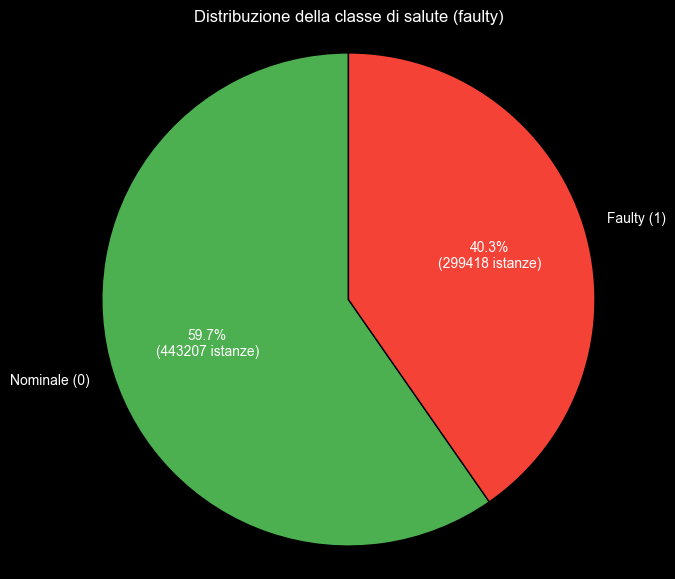

In [4]:
faulty_counts = df_y["faulty"].value_counts().sort_index()
labels = ["Nominale (0)", "Faulty (1)"]
colors = ["#4CAF50", "#F44336"]


def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f"{pct:.1f}%\n({count} istanze)"
    return my_format

plt.figure(figsize=(7, 7))
plt.pie(
    faulty_counts,
    labels=labels,
    autopct=autopct_format(faulty_counts.values),
    startangle=90,
    colors=colors,
    wedgeprops={"edgecolor": "black"}
)

plt.title("Distribuzione della classe di salute (faulty)")
plt.axis("equal")
plt.show()

La distribuzione della variabile faulty mostra uno sbilanciamento tra le classi, con una prevalenza di osservazioni in stato nominale rispetto a quelle guaste. Questo aspetto dovrà essere considerato nella fase di modellazione della classificazione.

## Influenza dello stato di salute sulle feature operative
In questa sezione viene analizzata l’influenza dello stato di salute del motore sulle principali feature operative.
L’obiettivo è verificare se le variabili misurate mostrino comportamenti differenti quando il motore opera in condizioni nominali (faulty = 0) rispetto a condizioni di guasto (faulty = 1).
Questa analisi rappresenta un passaggio fondamentale dell’Exploratory Data Analysis, in quanto consente di valutare il potenziale informativo delle singole feature rispetto allo stato di salute del motore e di guidare le successive fasi di selezione delle variabili e di modellazione.
Il confronto viene effettuato analizzando le distribuzioni delle feature nei due stati di salute attraverso rappresentazioni grafiche in grado di evidenziare differenze in termini di valore centrale, variabilità e forma della distribuzione.

### Analisi tramite box plot

I box plot vengono utilizzati come primo strumento di analisi per confrontare le distribuzioni delle feature operative tra motori nominali e guasti.
Questo tipo di grafico fornisce una sintesi robusta delle distribuzioni, basata sui quartili, ed è particolarmente adatto a individuare differenze sistematiche tra gruppi.
In particolare, i box plot consentono di:
- confrontare le mediane delle feature nei due stati di salute;
- osservare eventuali differenze nella dispersione dei dati;
- individuare la presenza di outlier, spesso associabili a condizioni operative anomale;
- valutare in modo preliminare il potere discriminante delle variabili rispetto allo stato di salute.

Le feature che mostrano uno spostamento significativo della mediana o una maggiore variabilità nello stato di guasto vengono considerate potenzialmente rilevanti e approfondite nelle analisi successive.

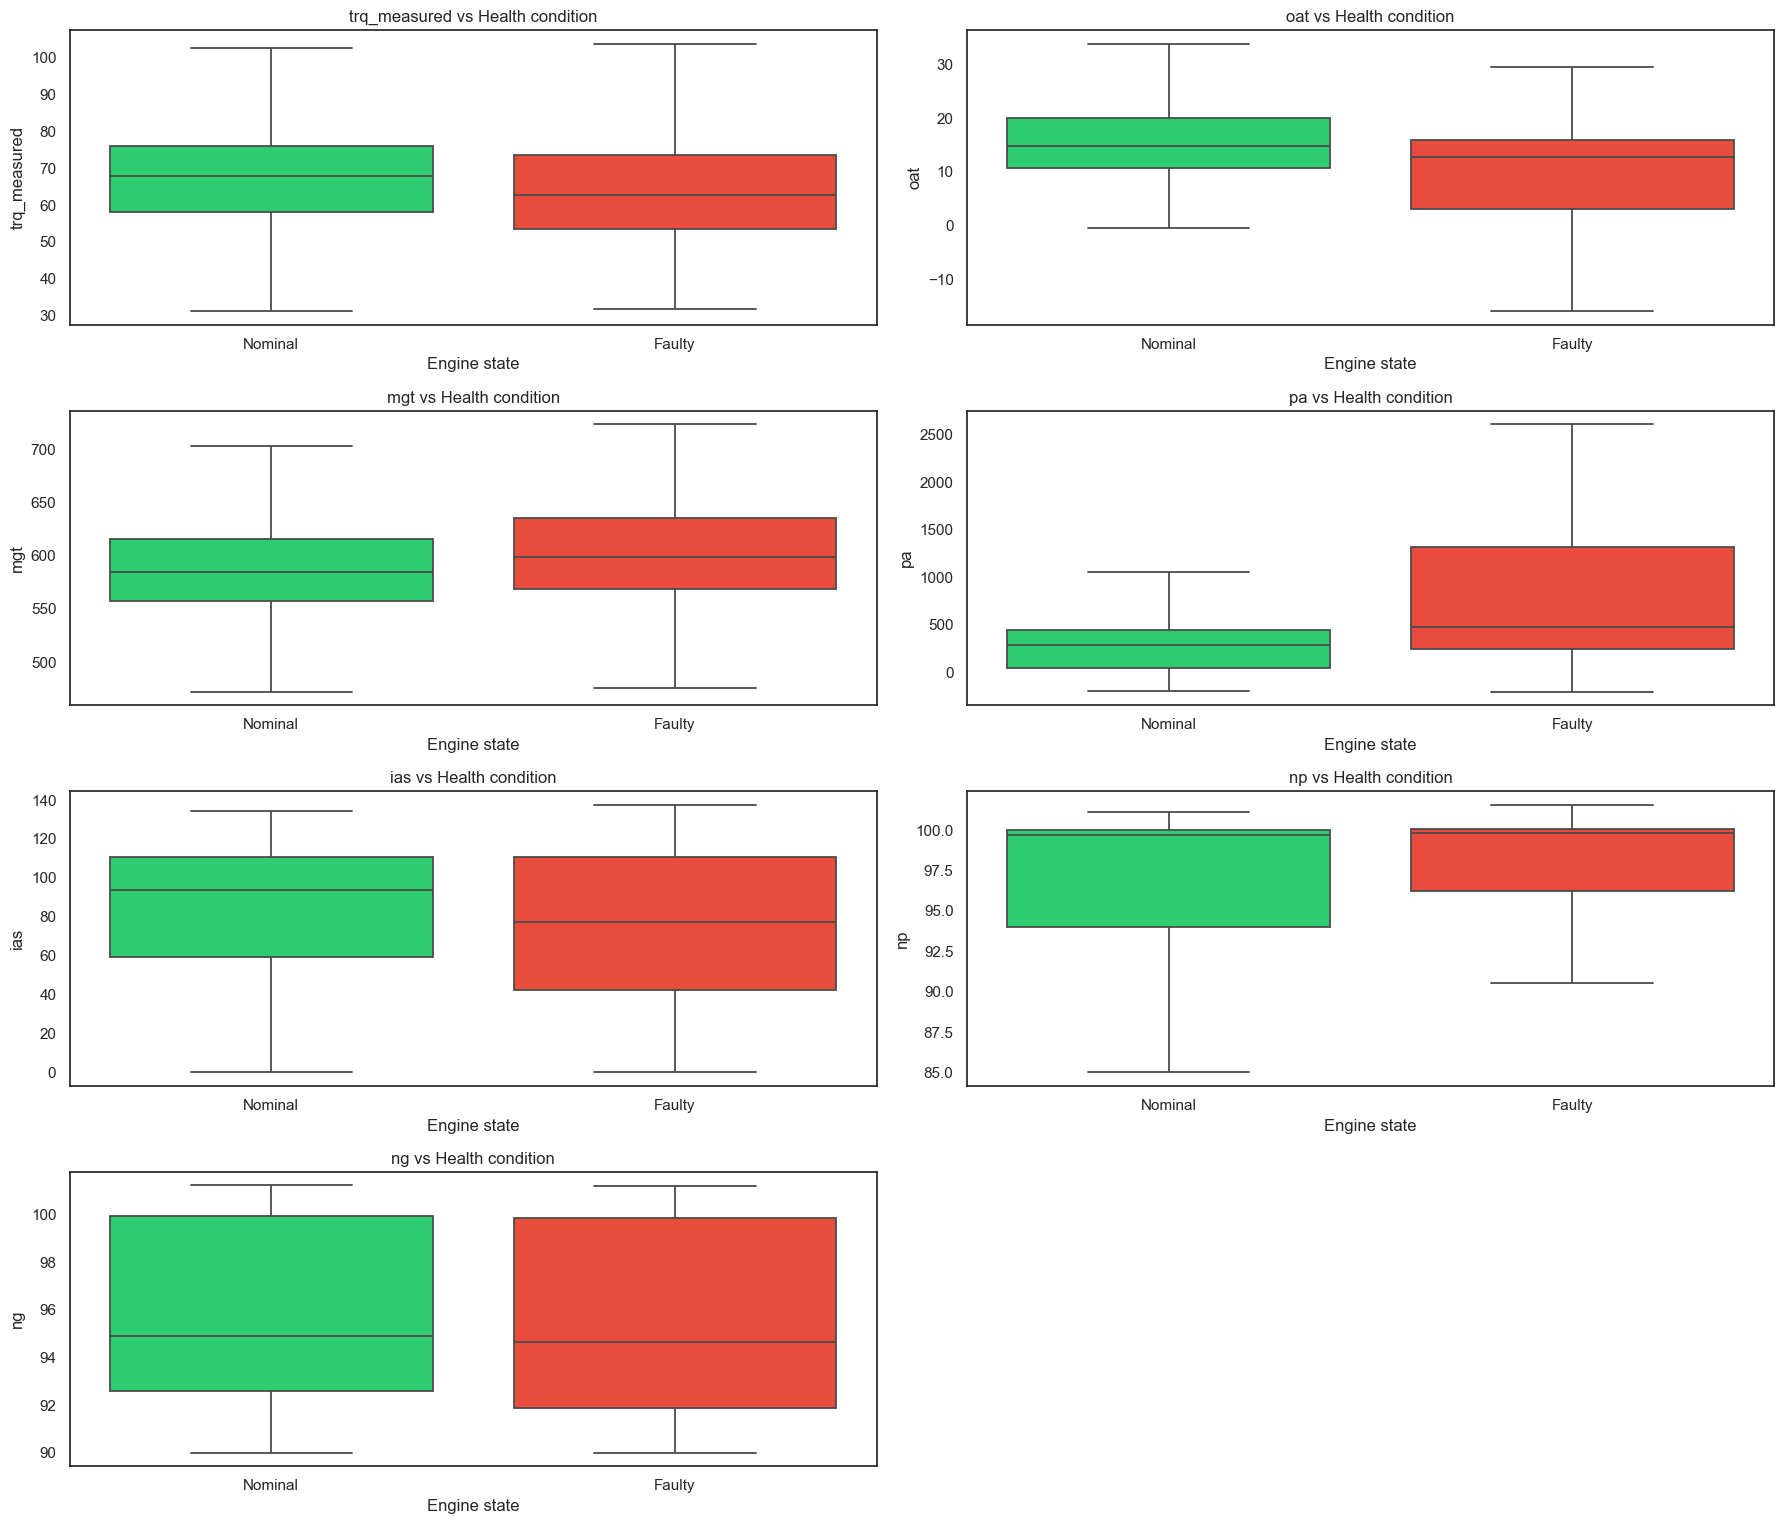

In [25]:
features = [col for col in df_x.columns if col.lower() != "id"]

palette = {
    0: "#2ECC71",
    1: "#E74C3C"
}

plt.figure(figsize=(18, len(features) * 2.2))

for i, feature in enumerate(features, 1):
    plt.subplot((len(features) + 1) // 2, 2, i)

    sns.boxplot(
        x=df_y["faulty"],
        y=df_x[feature],
        hue=df_y["faulty"],
        palette=palette,
        saturation=1,
        linewidth=1.3,
        showfliers=False,
        legend=False
    )

    plt.xlabel("Engine state")
    plt.ylabel(feature)
    plt.title(f"{feature} vs Health condition")
    plt.xticks([0, 1], ["Nominal", "Faulty"])

plt.tight_layout()
plt.show()


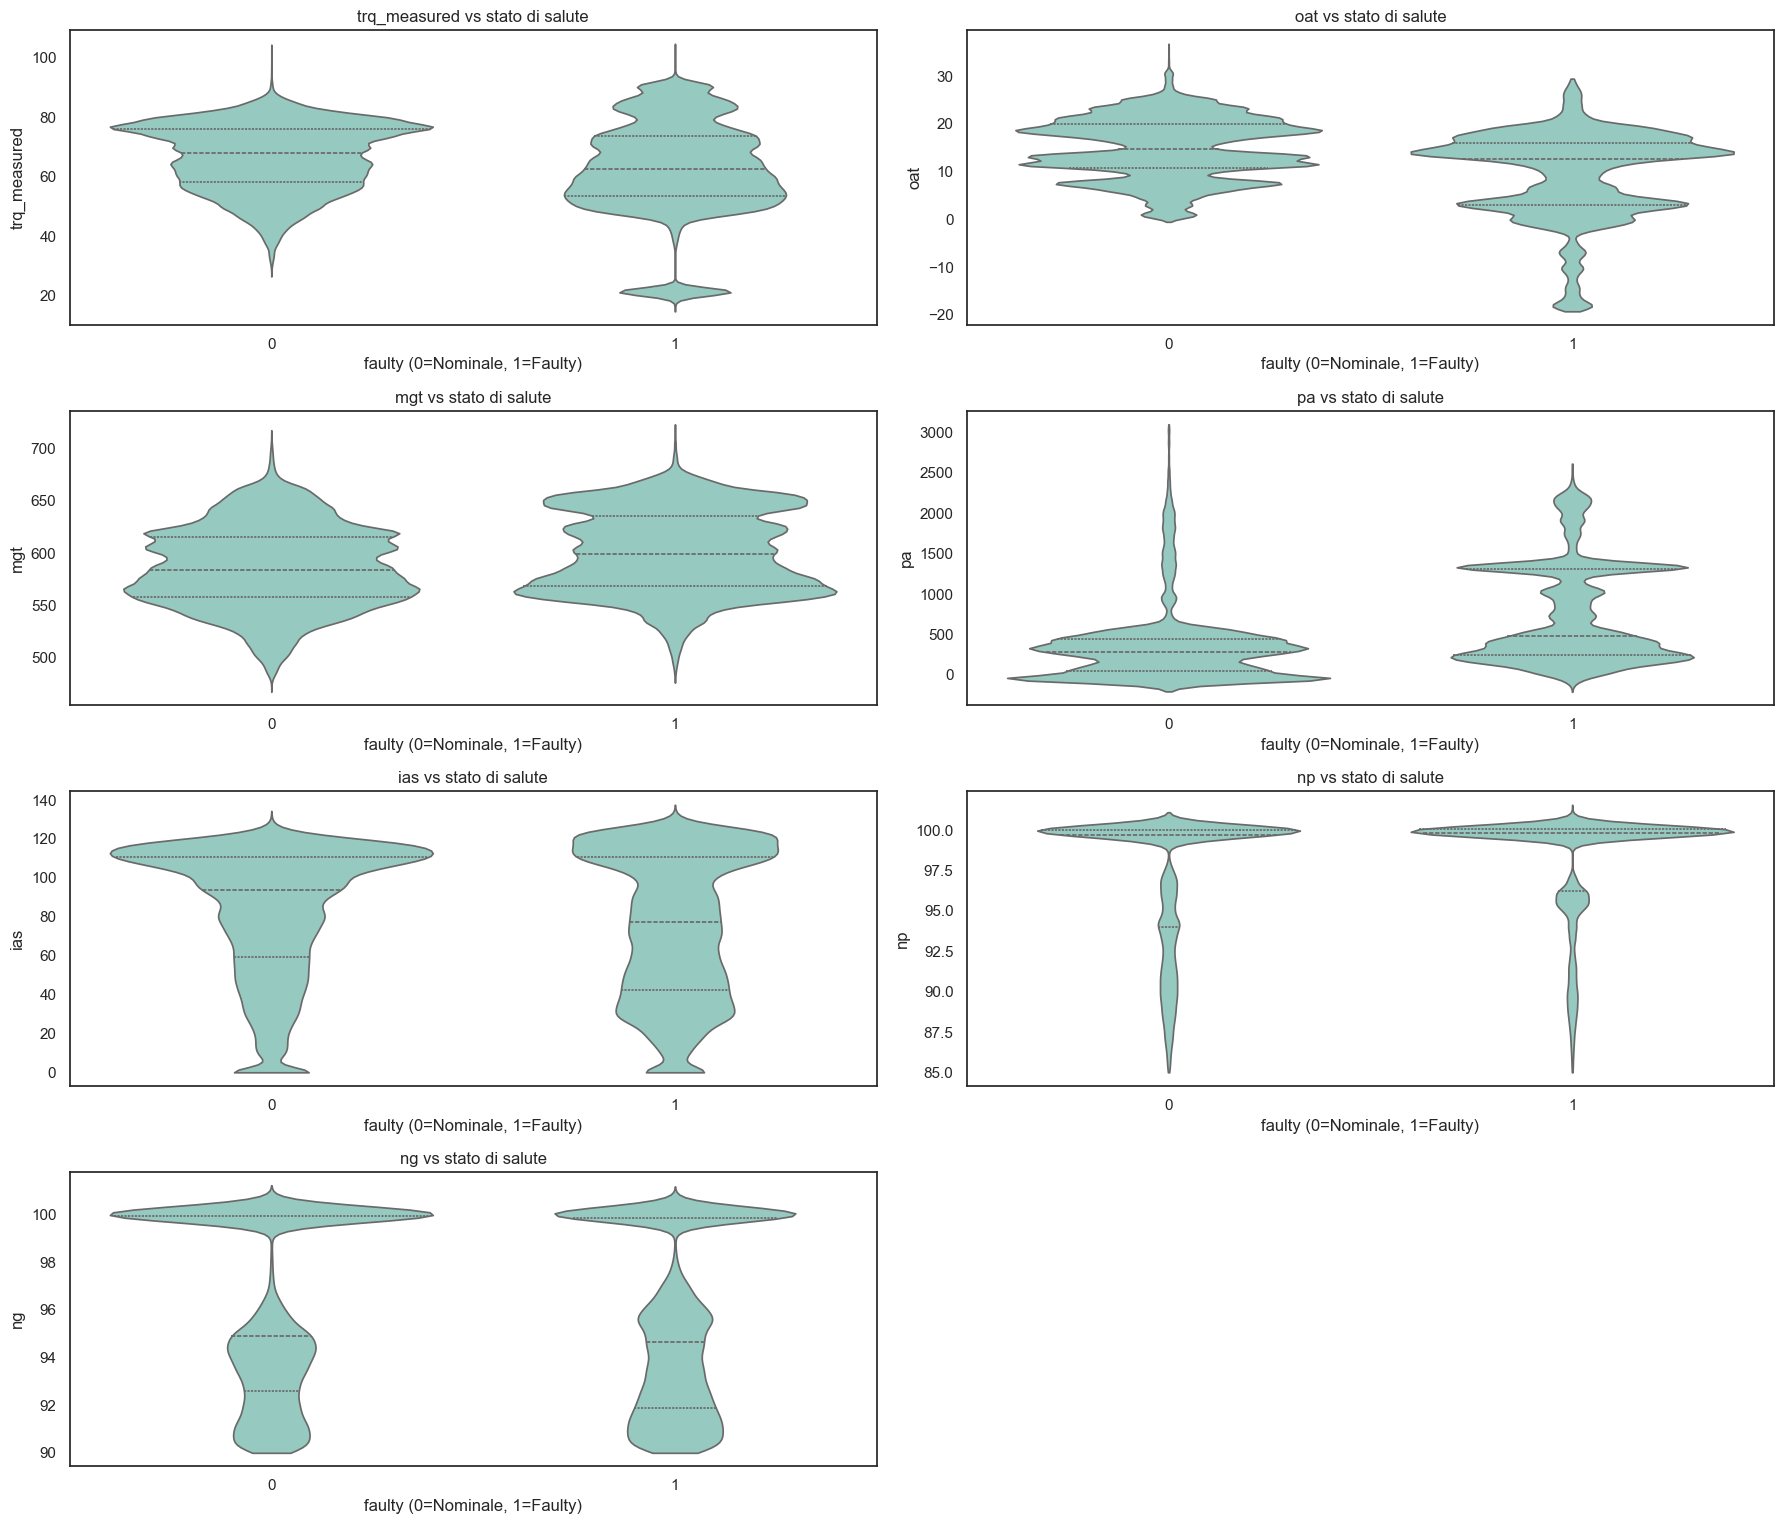

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

features = [col for col in df_x.columns if col.lower() != "id"]

plt.figure(figsize=(18, len(features) * 2.2))

for i, feature in enumerate(features, 1):
    plt.subplot((len(features) + 1) // 2, 2, i)
    sns.violinplot(
        x=df_y["faulty"],
        y=df_x[feature],
        inner="quartile",
        cut=0
    )
    plt.xlabel("faulty (0=Nominale, 1=Faulty)")
    plt.ylabel(feature)
    plt.title(f"{feature} vs stato di salute")

plt.tight_layout()
plt.show()

In [21]:
# Correlazione con il target
corr_with_target = (
    df.corr()["trq_target"]
    .drop("trq_target")
    .drop("trq_margin")
    .drop("trq_measured")
    .drop("faulty")
    .drop("id")
    .sort_values(key=abs, ascending=False)
)

corr_with_target

mgt    0.835092
oat   -0.489415
ias    0.442779
ng     0.401861
np     0.147781
pa     0.008343
Name: trq_target, dtype: float64

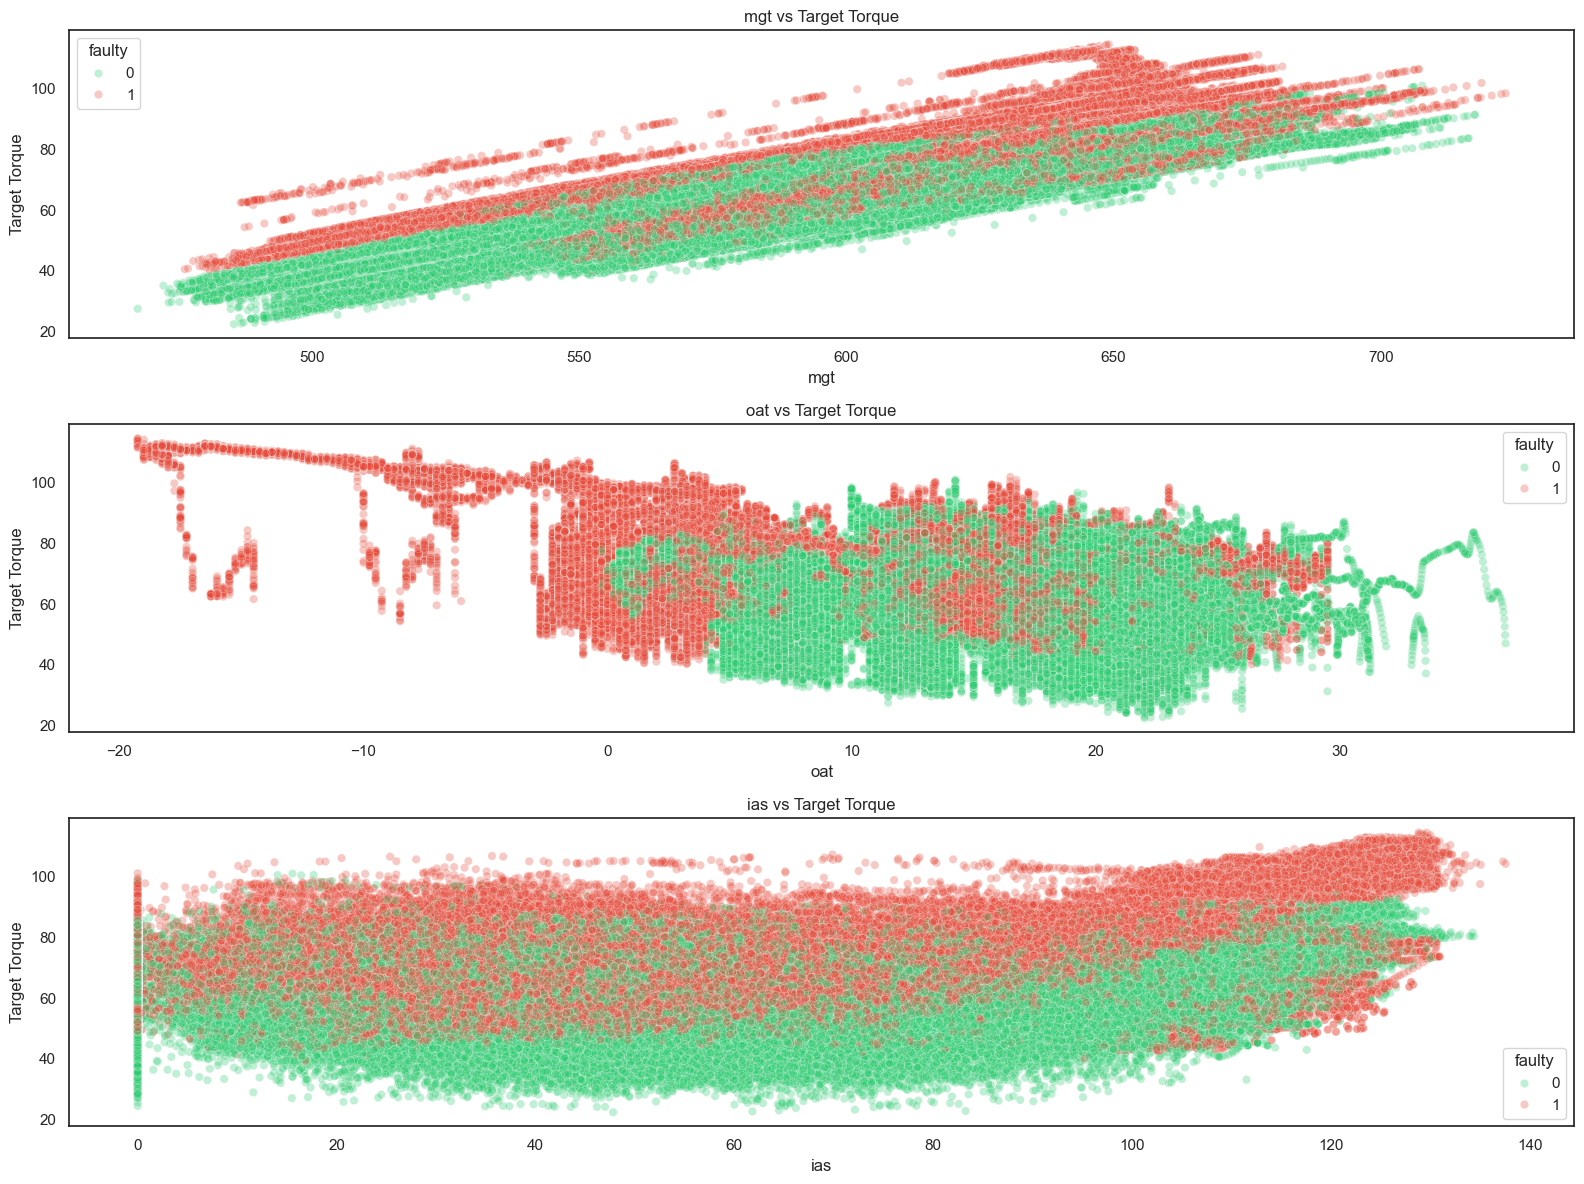

In [23]:
top_features = corr_with_target.head(3).index.tolist()
plt.figure(figsize=(16, 4 * len(top_features)))

for i, feature in enumerate(top_features, 1):
    plt.subplot(len(top_features), 1, i)
    sns.scatterplot(
        x=df_x[feature],
        y=df["trq_target"],
        hue=df_y["faulty"],
        palette=palette,
        alpha=0.3

    )
    plt.title(f"{feature} vs Target Torque")
    plt.xlabel(feature)
    plt.ylabel("Target Torque")

plt.tight_layout()
plt.show()